In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport
from sklearn.feature_selection import SelectFromModel
import plotly.express as px  # interactive charts
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from src.exception import CustomException
import os
from src.logger import logging
import sys
from datetime import datetime
from src.utils import DatabaseManager
from src.components.variable import dataBase
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


In [2]:
from src.utils import DatabaseManager

db=DatabaseManager()
df=db.execute_query('select * from marketing_campaign',fetch=True)

In [7]:
df['dt_customer'] = pd.to_datetime(df['dt_customer']) #dt_customer
newest_customer_date = df['dt_customer'].max()
oldest_customer_date = df['dt_customer'].min()
df['Customer_For'] = (newest_customer_date - df['dt_customer']).dt.days

current_year = datetime.now().year
df['Age'] = current_year - df['year_birth']
df['Spent'] = df[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum(axis=1)
df['living_with'] = df['marital_status'].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Single", "Widow": "Single", "YOLO": "Single", "Divorced": "Single", "Single": "Single"})
df['children'] = df['kidhome'] + df['teenhome']
df['Family_Size'] = df['living_with'].replace({"Single": 1, "Partner": 2,"Alone":1})
df['Is_Parent'] = np.where(df['children'] > 0, 1, 0)
df['education'] = df['education'].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors="coerce")
df.loc[(df['Age'] >= 13) & (df['Age'] <= 19), 'AgeGroup'] = 'Teen'
df.loc[(df['Age'] >= 20) & (df['Age']<= 39), 'AgeGroup'] = 'Adult'
df.loc[(df['Age'] >= 40) & (df['Age'] <= 59), 'AgeGroup'] = 'Middle Age Adult'
df.loc[(df['Age'] > 60), 'AgeGroup'] = 'Senior Adult'
df.rename(columns={
    "mntwines": "Wines",
    "mntfruits": "Fruits",
    "mntmeatproducts": "Meat",
    "mntfishproducts": "Fish",
    "mntsweetproducts": "Sweets",
    "mntgoldprods": "Gold"
}, inplace=True)

df.Family_Size=df.Family_Size.astype(int)

In [8]:
data = df.copy()
to_drop = ["marital_status", "dt_customer", "z_costcontact", "z_revenue", "year_birth", "id","AgeGroup","living_with"]
data.drop(to_drop, axis=1, inplace=True)

data.Is_Parent = pd.to_numeric(data.Is_Parent, errors='coerce')

In [9]:
data.dtypes

education               object
income                 float64
kidhome                  int64
teenhome                 int64
recency                  int64
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
Gold                     int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
response                 int64
Customer_For             int64
Age                      int64
Spent                    int64
children                 int64
Family_Size              int32
Is_Parent                int32
dtype: object

In [10]:
data.education

0           Graduate
1           Graduate
2           Graduate
3           Graduate
4       Postgraduate
            ...     
2235        Graduate
2236    Postgraduate
2237        Graduate
2238    Postgraduate
2239    Postgraduate
Name: education, Length: 2240, dtype: object

In [11]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

data[object_cols]

,education
0,Graduate
1,Graduate
2,Graduate
3,Graduate
4,Postgraduate
...,...
2235,Graduate
2236,Postgraduate
2237,Graduate
2238,Postgraduate


In [12]:
LE = LabelEncoder()
for i in object_cols:
    data[i] = LE.fit_transform(data[i])

In [ ]:
import pandas as pd
import numpy as np
from src.exception import CustomException
import os
from src.logger import logging
import sys
from datetime import datetime
from src.utils import DatabaseManager
from src.components.variable import dataBase
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

class DataCleaning:
    def __init__(self):
        self.db = DatabaseManager()
        self.conn = dataBase.conn

    def process_data_and_reduce_dimensionality(self, filename):

        try:
            logging.info('Database table reading start in data_process.py')
            df=self.db.execute_query(f'select * from {filename}',fetch=True)
            logging.info('In data_process.py database table converted into df')

        except Exception as e:
            logging.info('Exception occurred at data_process.py in table reading from db stage')
            raise CustomException(e,sys)

        # Process df data
        df['dt_customer'] = pd.to_datetime(df['dt_customer']) #dt_customer
        newest_customer_date = df['dt_customer'].max()
        oldest_customer_date = df['dt_customer'].min()
        df['Customer_For'] = (newest_customer_date - df['dt_customer']).dt.days

        current_year = datetime.now().year
        df['Age'] = current_year - df['year_birth']
        df['Spent'] = df[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum(axis=1)
        df['living_with'] = df['marital_status'].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Single", "Widow": "Single", "YOLO": "Single", "Divorced": "Single", "Single": "Single"})
        df['children'] = df['kidhome'] + df['teenhome']
        df['Family_Size'] = df['living_with'].replace({"Single": 1, "Partner": 2})
        df['Is_Parent'] = np.where(df['children'] > 0, 1, 0)
        df['education'] = df['education'].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
        df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors="coerce")
        # df.loc[(df['Age'] >= 13) & (df['Age'] <= 19), 'AgeGroup'] = 'Teen'
        # df.loc[(df['Age'] >= 20) & (df['Age']<= 39), 'AgeGroup'] = 'Adult'
        # df.loc[(df['Age'] >= 40) & (df['Age'] <= 59), 'AgeGroup'] = 'Middle Age Adult'
        # df.loc[(df['Age'] > 60), 'AgeGroup'] = 'Senior Adult'
        df.rename(columns={
            "mntwines": "Wines",
            "mntfruits": "Fruits",
            "mntmeatproducts": "Meat",
            "mntfishproducts": "Fish",
            "mntsweetproducts": "Sweets",
            "mntgoldprods": "Gold"
        }, inplace=True)


        filename2 = 'Without_encoding'

        try:
            self.db.execute_values(df, filename2)
            logging.info('DataFrame data values have been successfully uploaded to the database table')

        except Exception as e:
            logging.info('Exception occurred at data_process.py file during creating table/execute_value')
            raise CustomException(e, sys)


        data = df.copy()
        to_drop = ["marital_status", "dt_customer", "z_costcontact", "z_revenue", "year_birth", "id"]
        data.drop(to_drop, axis=1, inplace=True)

        data.Is_Parent = pd.to_numeric(data.Is_Parent, errors='coerce')



        #Get list of categorical variables
        s = (data.dtypes == 'object')
        object_cols = list(s[s].index)

        LE = LabelEncoder()
        for i in object_cols:
            data[i] = LE.fit_transform(data[i])
            
        print("All features are now numerical")


        
        filename1 = 'cleaned_data'

        try:
            # self.db.create_table(data, filename1)
            # logging.info(f'Successfully created table in the database table name: {filename1}')



            self.db.execute_values(data, filename1)
            logging.info('DataFrame data values have been successfully uploaded to the database table')

        except Exception as e:
            logging.info('Exception occurred at data_process.py file during creating table/execute_value')
            raise CustomException(e, sys)

        return filename1,filename2

# data_transformer = DataTransformationConfig()

# # Step 2: Load your data into a pandas DataFrame
# # Assuming you have your data in a CSV file named 'customer_data.csv'
# db=DatabaseManager()
# customer_data = db.execute_query('select * from marketing_campaign',fetch=True)

# # Step 3: Call the process_data_and_reduce_dimensionality method and pass the DataFrame
# filename1= data_transformer.process_data_and_reduce_dimensionality(customer_data)

# df1=db.execute_query(f'select * from {filename1}',fetch=True)
# logging.info(f'file names is : {filename1}')
# logging.info(f'df1: \n {df1.head()}')

In [2]:
from src.utils import DatabaseManager

db=DatabaseManager()
df=db.execute_query('select * from merge_table',fetch=True)

In [6]:
df

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,wines,...,response,customer_for,age,spent,living_with,children,family_size,is_parent,agegroup,clusters
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,1,663,66,1617,Single,0,1,0,Senior Adult,2
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,0,113,69,27,Single,2,1,1,Senior Adult,1
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,0,312,58,776,Partner,0,2,0,Middle Age Adult,2
3,6182,1984,Graduate,Together,26646.0,1,0,2014-02-10,26,11,...,0,139,39,53,Partner,1,2,1,Adult,3
4,5324,1981,Postgraduate,Married,58293.0,1,0,2014-01-19,94,173,...,0,161,42,422,Partner,1,2,1,Middle Age Adult,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,10870,1967,Graduate,Married,61223.0,0,1,2013-06-13,46,709,...,0,381,56,1341,Partner,1,2,1,Middle Age Adult,2
2201,4001,1946,Postgraduate,Together,64014.0,2,1,2014-06-10,56,406,...,0,19,77,444,Partner,3,2,1,Senior Adult,1
2202,7270,1981,Graduate,Divorced,56981.0,0,0,2014-01-25,91,908,...,0,155,42,1241,Single,0,1,0,Middle Age Adult,2
2203,8235,1956,Postgraduate,Together,69245.0,0,1,2014-01-24,8,428,...,0,156,67,843,Partner,1,2,1,Senior Adult,1


In [3]:
import seaborn as sns

In [25]:
import pandas as pd
import plotly.express as px

# Assuming you have the 'agegroup' and 'spent' data in a DataFrame called df
agegroupspending = df.groupby('agegroup')['spent'].mean().sort_values(ascending=False).reset_index()

fig = px.bar(agegroupspending,
             x='spent',
             y='agegroup',
             orientation='h',  # Horizontal bar chart
             title='Average Spending by Age Group',
             labels={'spent': 'Average Spending', 'agegroup': 'Age Group'},
             color='agegroup',
             color_discrete_sequence=['#e28f71', '#b43058', '#57274e'],
             width=1000,height=400
             
             )  # Use custom colors

# Customize the layout
fig.update_layout(
    autosize=False,
    xaxis=dict(title=dict(text='Average Spending')),
    yaxis=dict(title=dict(text='Age Group')),
    font=dict(size=12),
    showlegend=False,
    margin=dict(l=100, r=50, b=50, t=50),  # Adjust margins as needed
)

# Show the plot
fig.show()


Text(0, 0.5, 'Total Spendings')

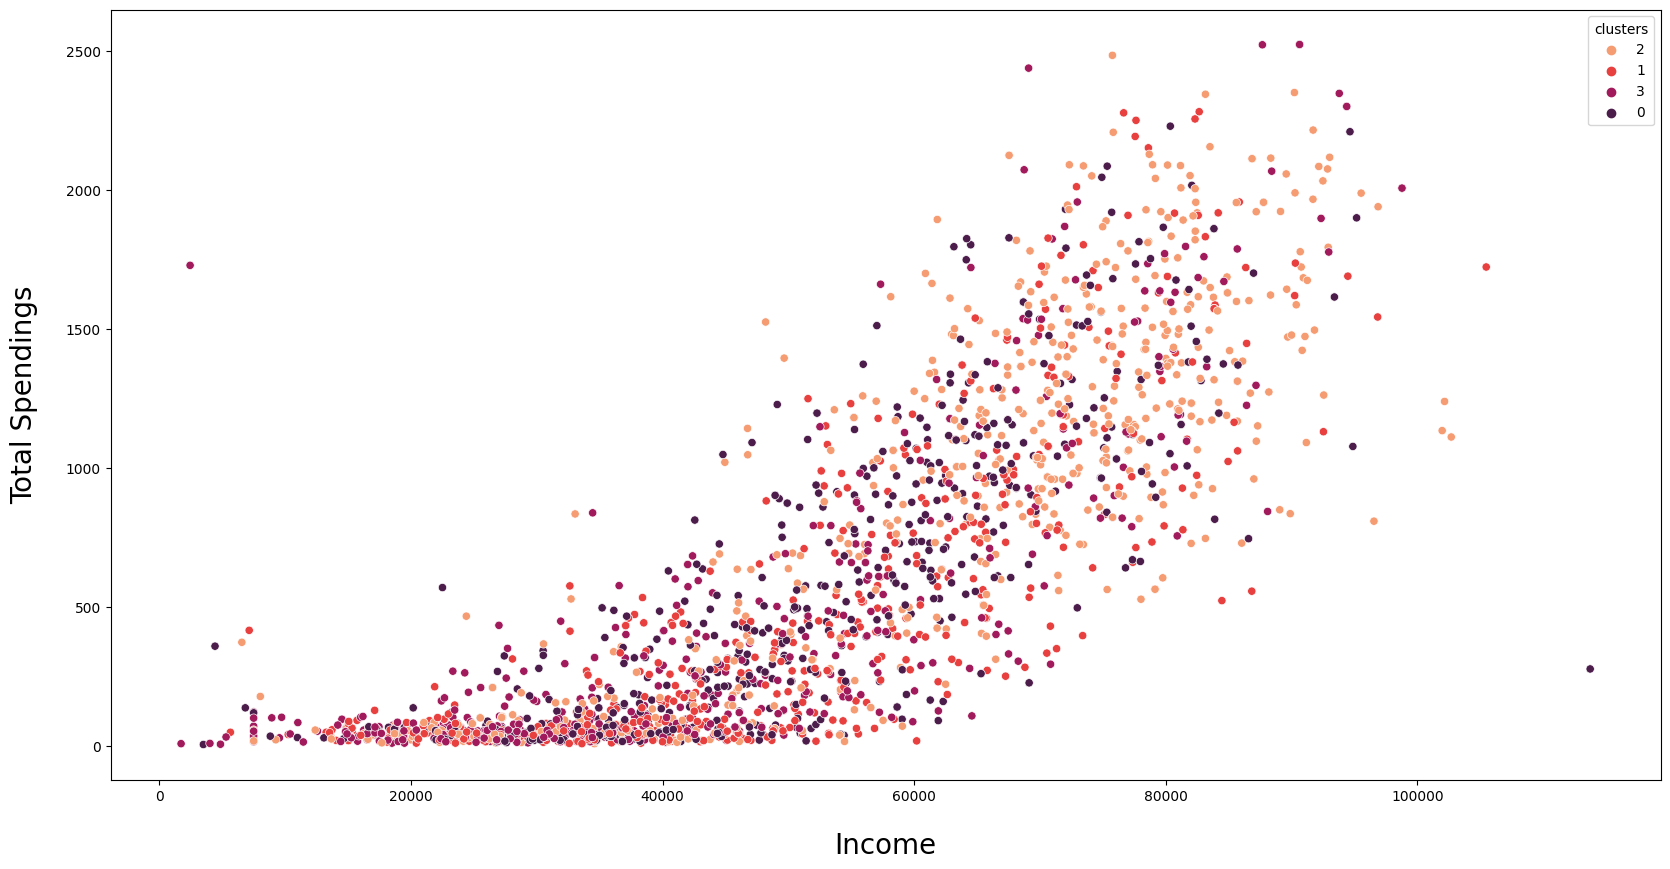

In [56]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x='income', y='spent', hue='clusters', palette='rocket_r')
plt.xlabel('Income', fontsize=20, labelpad=20)
plt.ylabel('Total Spendings', fontsize=20, labelpad=20)

In [53]:
import plotly.express as px
maritalspending = df.groupby('living_with')['spent'].mean().sort_values(ascending=False)
maritalspending_df = pd.DataFrame(list(maritalspending.items()), columns=['Marital Status', 'Average Spending'])

fig = px.bar(
    maritalspending_df, 
    x='Average Spending', 
    y='Marital Status',
    orientation='h',
    color_discrete_sequence=['#b43058', '#57274e', '#472345', '#d35454', '#b2182b'],
    color='Marital Status',
    title='Average Spending by Marital Status',
    labels={'Average Spending': 'Average Spending', 'Marital Status': 'Marital Status'},
)

fig.update_layout(
    yaxis=dict(tickfont=dict(size=12)),
    xaxis=dict(tickfont=dict(size=12)),
    showlegend=False,
    xaxis_title=dict(text='Average Spending', font=dict(size=13), standoff=13),
    yaxis_title=dict(text='Marital Status', font=dict(size=13), standoff=13),
)

fig.show()


Text(0, 0.5, 'Marital Status')

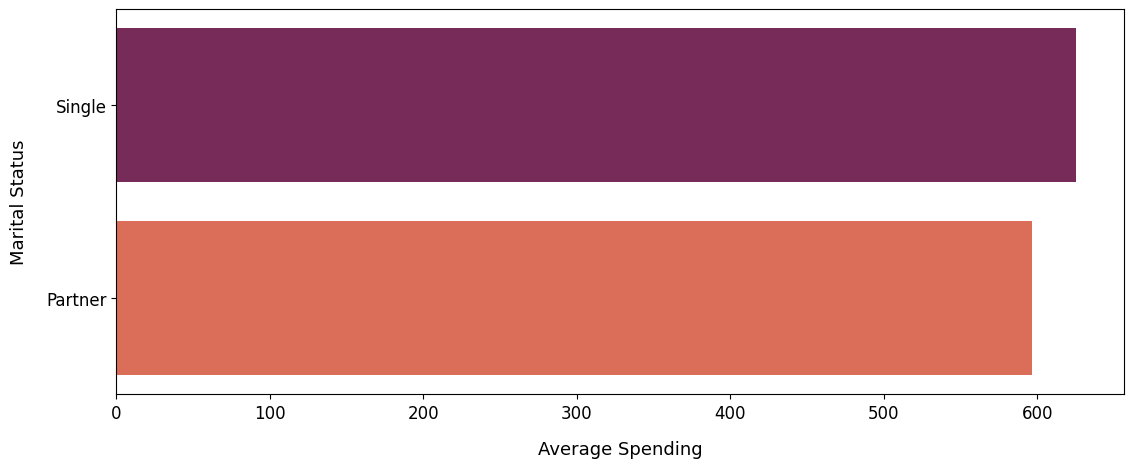

In [46]:
df.living_with=df.living_with.str.replace('Alone','Single')
maritalspending = df.groupby('living_with')['spent'].mean().sort_values(ascending=False)
maritalspending_df = pd.DataFrame(list(maritalspending.items()), columns=['Marital Status', 'Average Spending'])

plt.figure(figsize=(13,5))
sns.barplot(data = maritalspending_df, x="Average Spending", y="Marital Status", palette='rocket');

plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.xlabel('Average Spending', fontsize=13, labelpad=13)
plt.ylabel('Marital Status', fontsize=13, labelpad=13)

In [38]:
import pandas as pd
import plotly.express as px

# Assuming you have the product data in a DataFrame called 'customer'
products = df[['wines', 'fruits', 'meat', 'fish', 'sweets', 'gold']]
product_means = products.mean(axis=0).sort_values(ascending=False)
product_means_df = pd.DataFrame(list(product_means.items()), columns=['Product', 'Average Spending'])

fig = px.bar(product_means_df,
             x='Average Spending',
             y='Product',
             title='Average Spending on Products',
             orientation='h',
             color='Product',
             labels={'Product': 'Product', 'Average Spending': 'Average Spending'},
             color_discrete_sequence=['#e28f71', '#b43058', '#57274e', '#472345', '#d35454', '#b2182b'])  # Custom colors

# Customize the layout
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    xaxis=dict(title=dict(text='Product')),
    yaxis=dict(title=dict(text='Average Spending')),
    showlegend=False,
    font=dict(size=16),
    margin=dict(l=100, r=50, b=80, t=50),  # Adjust margins as needed
)

# Show the plot
fig.show()


Text(0, 0.5, 'Age Group')

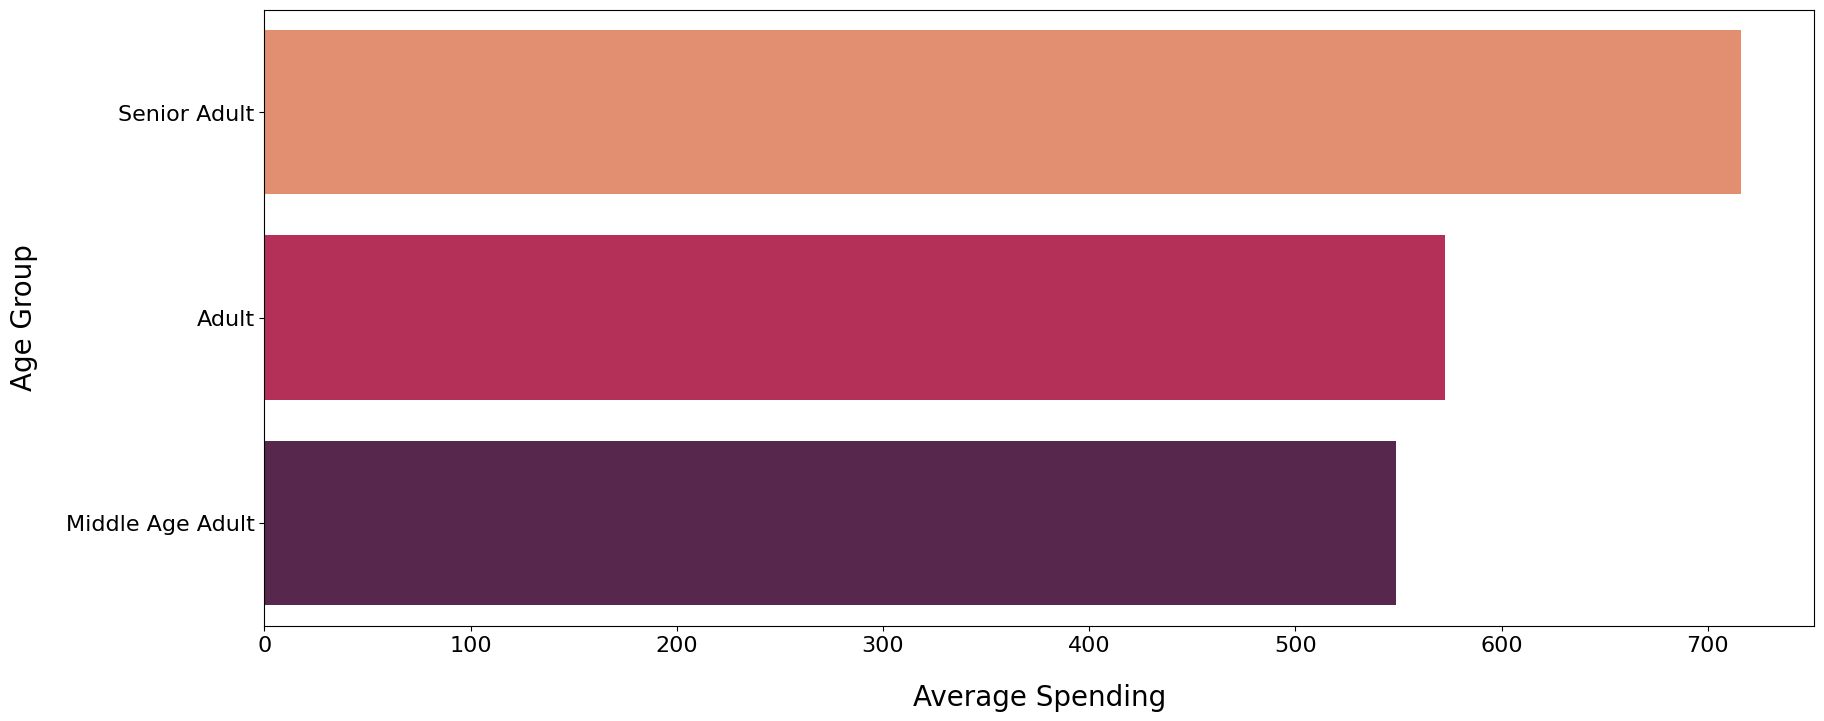

In [14]:
agegroupspending = df.groupby('agegroup')['spent'].mean().sort_values(ascending=False)
agegroupspending_df = pd.DataFrame(list(agegroupspending.items()), columns=['Age Group', 'Average Spending'])

plt.figure(figsize=(20,8))

sns.barplot(data = agegroupspending_df, x="Average Spending", y='Age Group', palette='rocket_r')
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Average Spending', fontsize=20, labelpad=20)
plt.ylabel('Age Group', fontsize=20, labelpad=20)

In [17]:
df = df[df.age < 100]
df = df[df.income < 120000]

Text(0, 0.5, 'income')

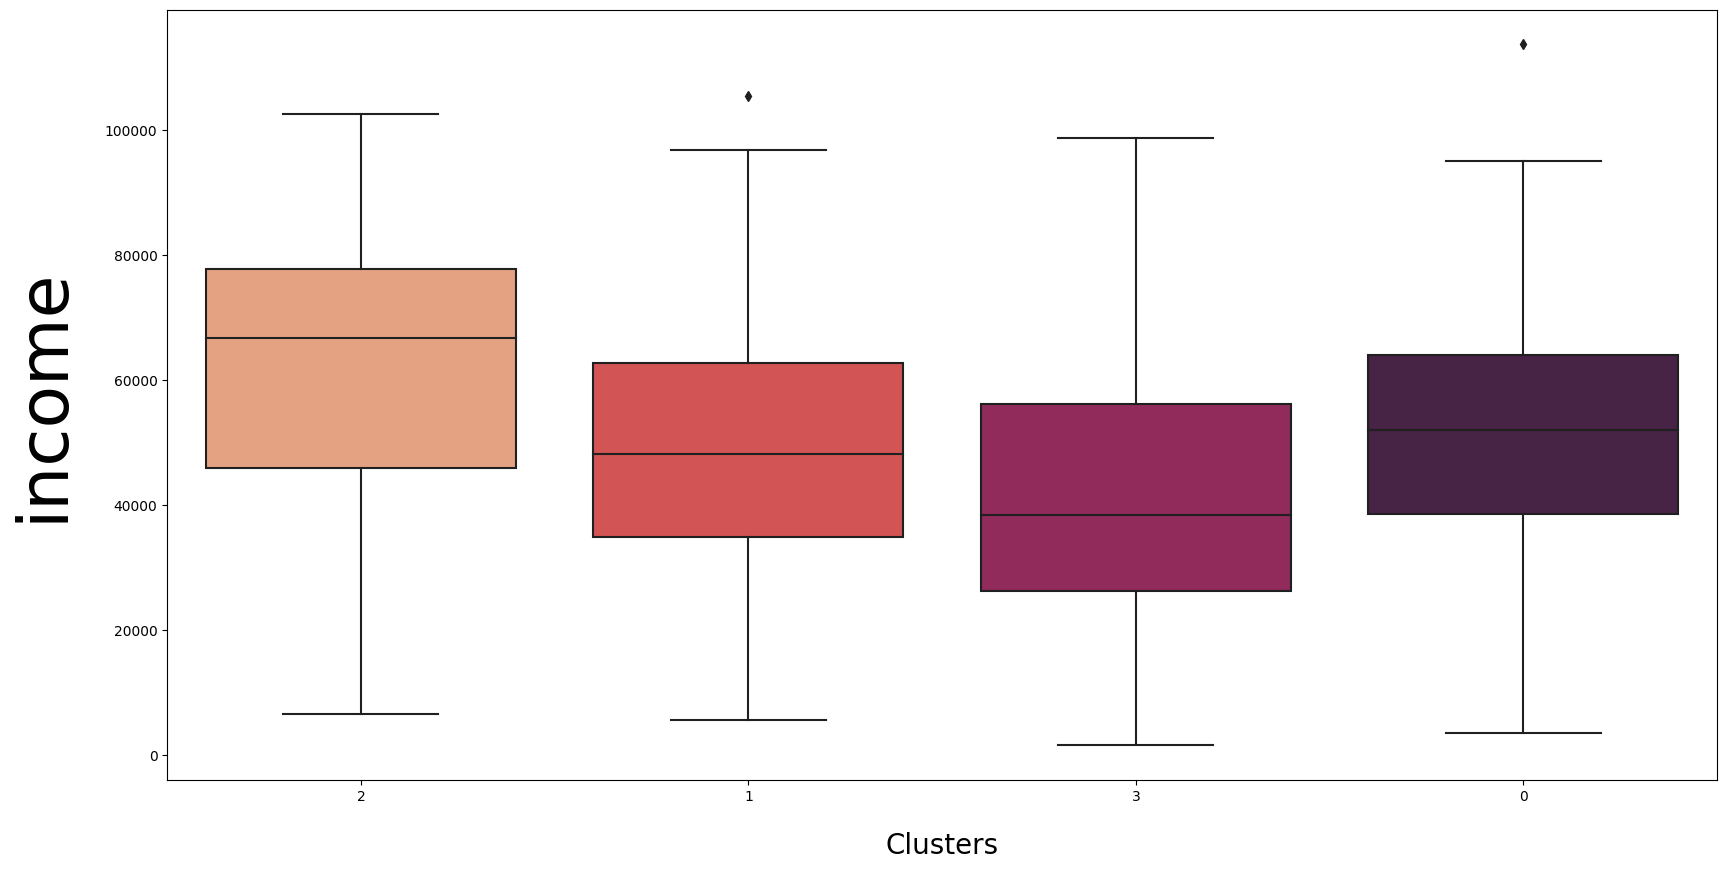

In [5]:
#Income
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'income',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('income', fontsize=50, labelpad=20)

Text(0, 0.5, 'Spendings')

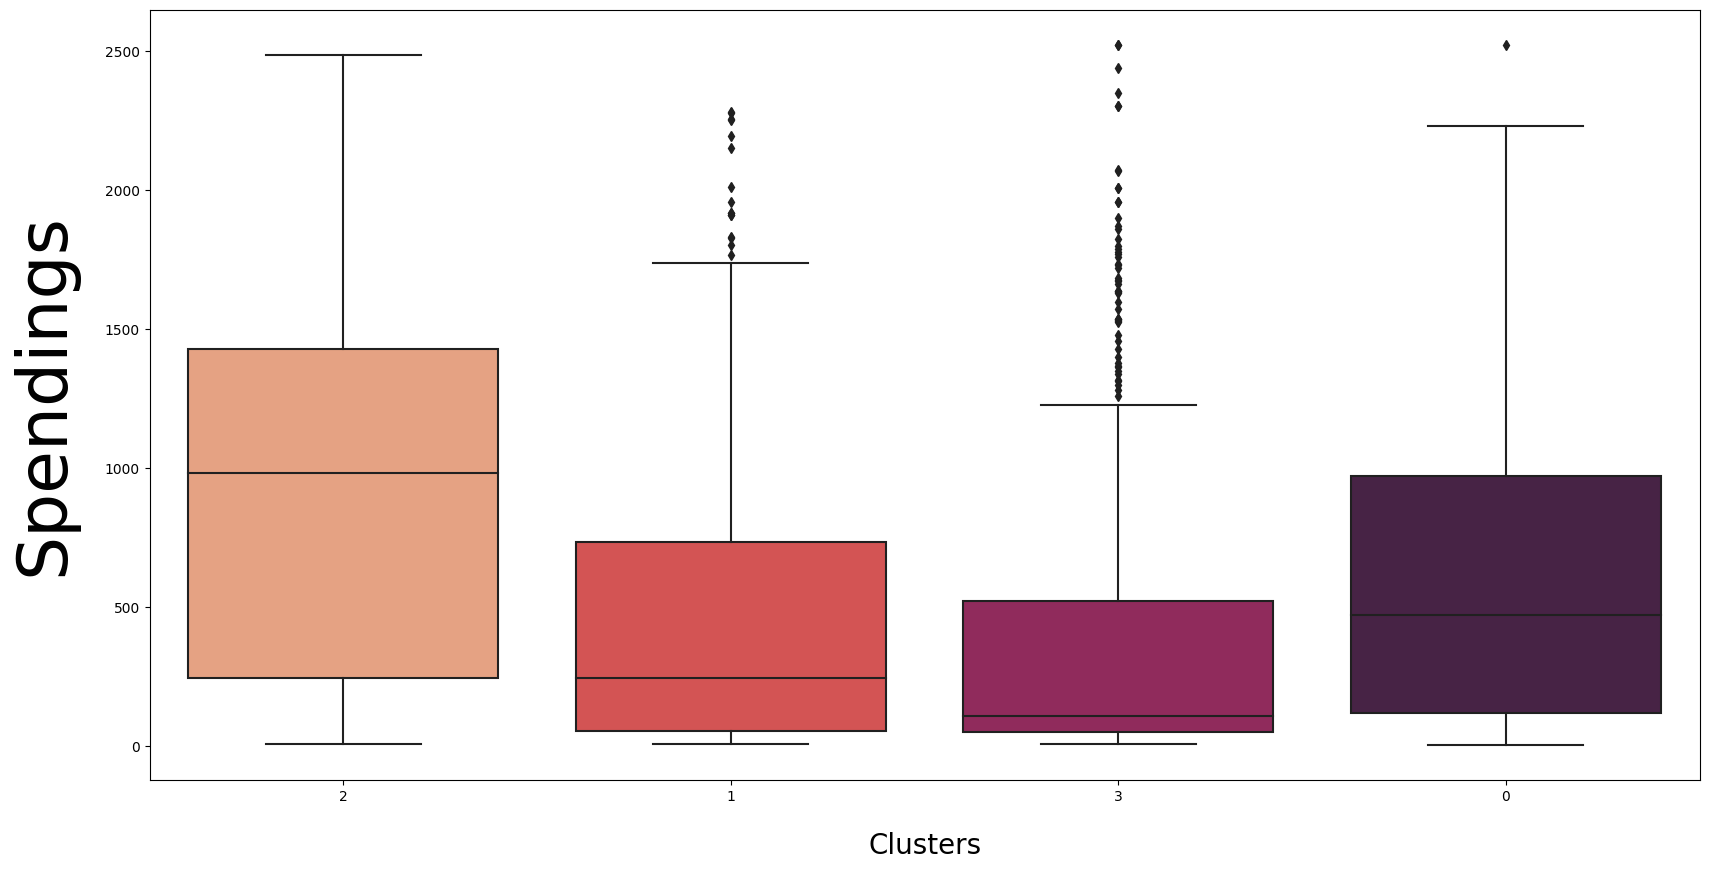

In [6]:
#Total Spending
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'spent',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Spendings', fontsize=50, labelpad=20)

In [7]:
df

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,wines,...,response,customer_for,age,spent,living_with,children,family_size,is_parent,agegroup,clusters
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,1,663,66,1617,Single,0,1,0,Senior Adult,2
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,0,113,69,27,Single,2,1,1,Senior Adult,1
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,0,312,58,776,Partner,0,2,0,Middle Age Adult,2
3,6182,1984,Graduate,Together,26646.0,1,0,2014-02-10,26,11,...,0,139,39,53,Partner,1,2,1,Adult,3
4,5324,1981,Postgraduate,Married,58293.0,1,0,2014-01-19,94,173,...,0,161,42,422,Partner,1,2,1,Middle Age Adult,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,10870,1967,Graduate,Married,61223.0,0,1,2013-06-13,46,709,...,0,381,56,1341,Partner,1,2,1,Middle Age Adult,2
2201,4001,1946,Postgraduate,Together,64014.0,2,1,2014-06-10,56,406,...,0,19,77,444,Partner,3,2,1,Senior Adult,1
2202,7270,1981,Graduate,Divorced,56981.0,0,0,2014-01-25,91,908,...,0,155,42,1241,Single,0,1,0,Middle Age Adult,2
2203,8235,1956,Postgraduate,Together,69245.0,0,1,2014-01-24,8,428,...,0,156,67,843,Partner,1,2,1,Senior Adult,1


Text(0, 0.5, 'Month Since Customer')

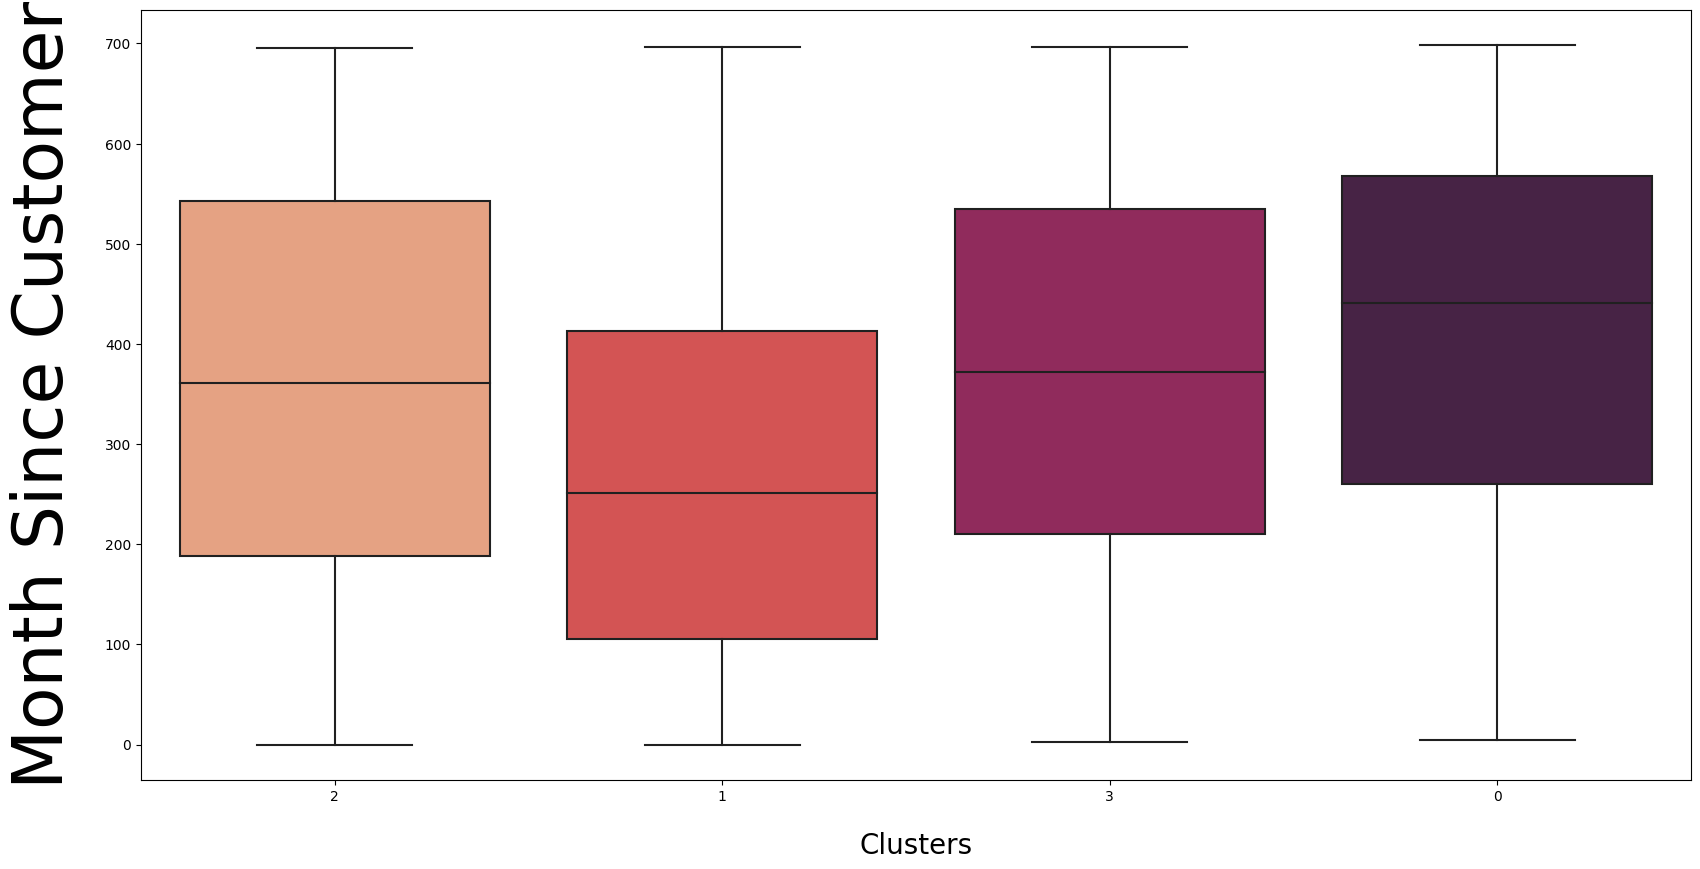

In [8]:
#Month Since Customer
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'customer_for',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Month Since Customer', fontsize=50, labelpad=20)

Text(0, 0.5, 'Age')

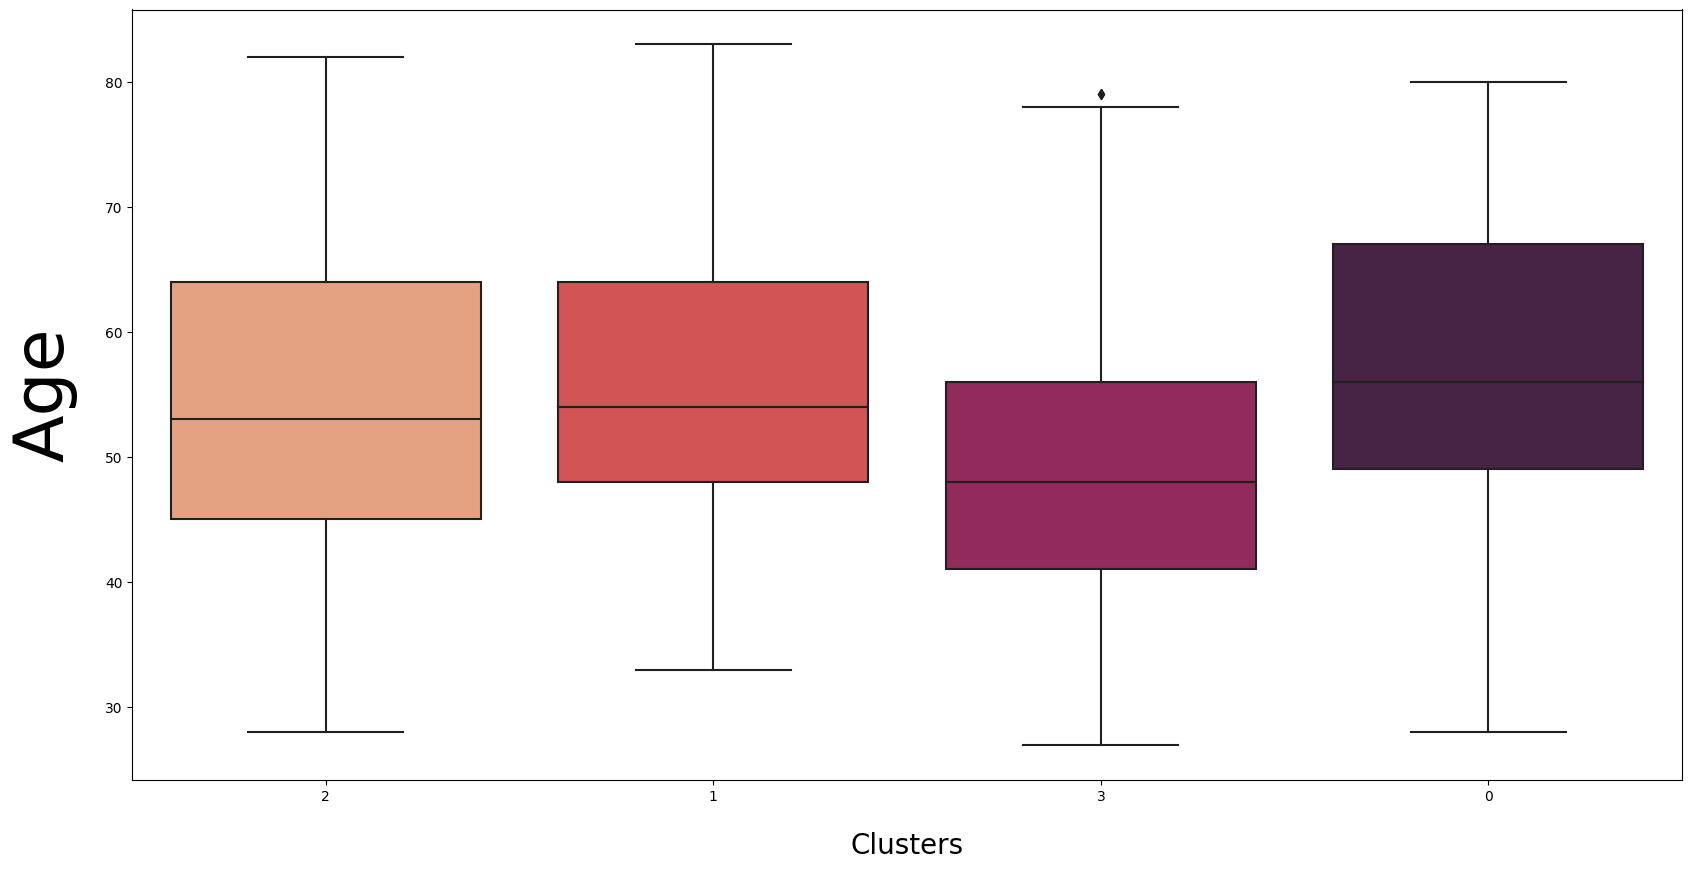

In [9]:
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'age',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Age', fontsize=50, labelpad=20)

Text(0, 0.5, 'No. of Children')

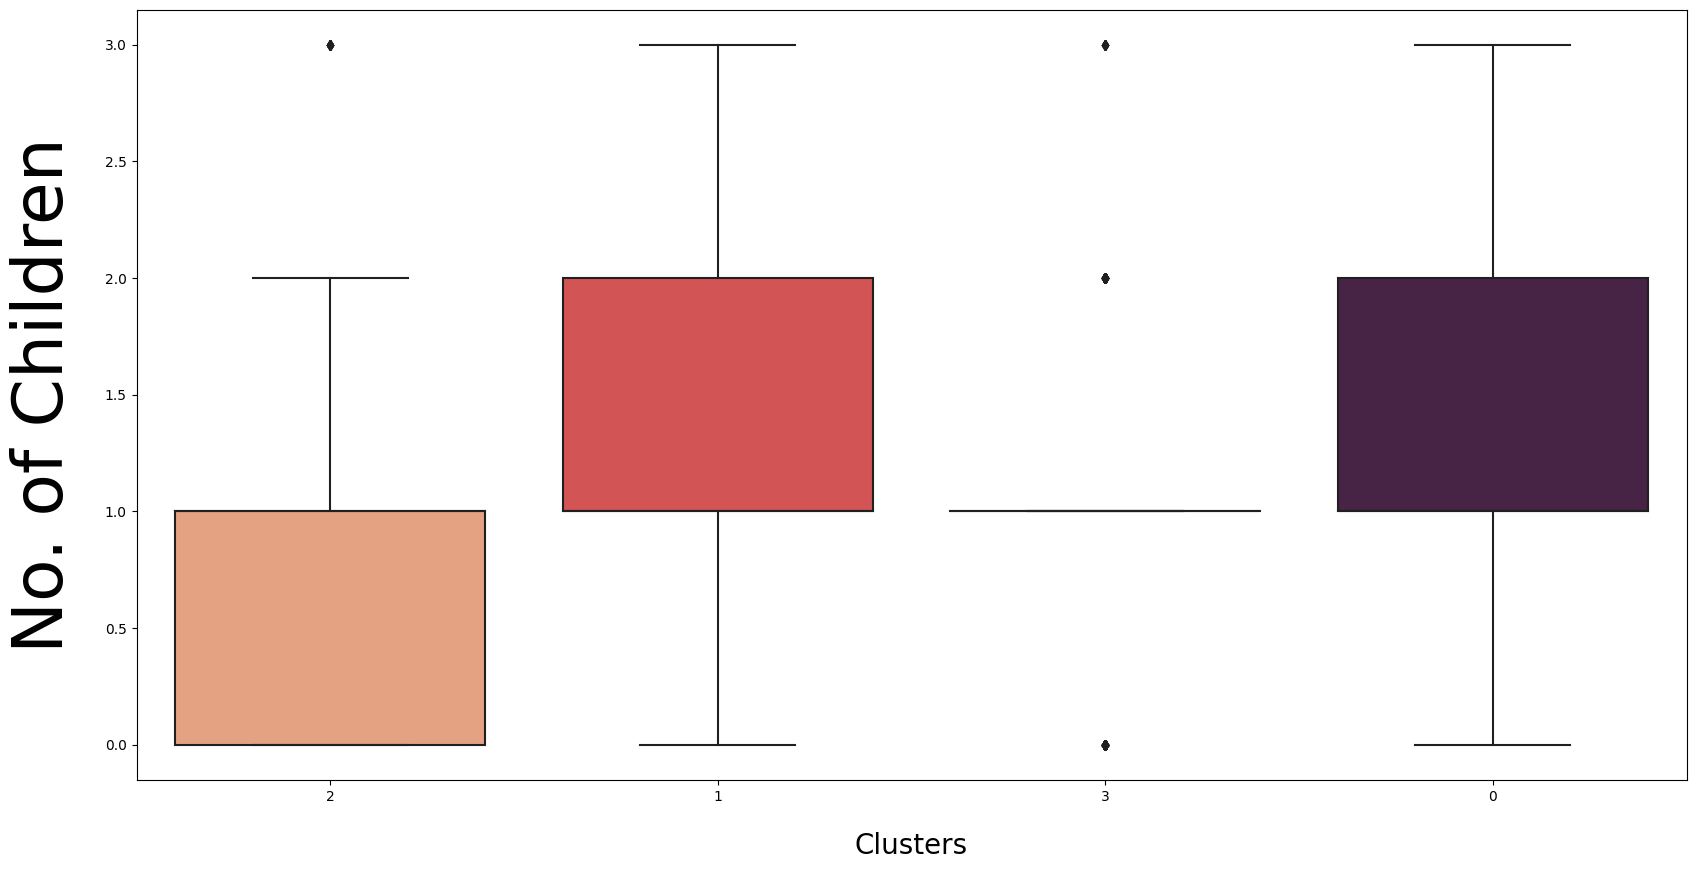

In [10]:
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'children',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('No. of Children', fontsize=50, labelpad=20)

In [71]:
df = df.replace({'clusters': {'0': 'Bronze', '3': 'Platinum', '2': 'Silver', '1': 'Gold'}})


In [72]:
df

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters
0,0.0,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,66,1617,0.0,0,1,0.0,Gold
1,0.0,46344.0,1,1,38,11,1,6,2,1,...,0,0,113,69,27,0.0,2,1,1.0,Platinum
2,0.0,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,58,776,1.0,0,2,0.0,Gold
3,0.0,26646.0,1,0,26,11,4,20,10,3,...,0,0,139,39,53,1.0,1,2,1.0,Bronze
4,1.0,58293.0,1,0,94,173,43,118,46,27,...,0,0,161,42,422,1.0,1,2,1.0,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.0,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,56,1341,1.0,1,2,1.0,Gold
2236,1.0,64014.0,2,1,56,406,0,30,0,0,...,0,0,19,77,444,1.0,3,2,1.0,Platinum
2237,0.0,56981.0,0,0,91,908,48,217,32,12,...,0,0,155,42,1241,0.0,0,1,0.0,Gold
2238,1.0,69245.0,0,1,8,428,30,214,80,30,...,0,0,156,67,843,1.0,1,2,1.0,Platinum


In [24]:
df['children'].value_counts()

children
1    1112
0     628
2     415
3      50
Name: count, dtype: int64

In [12]:
children_counts = df['children'].value_counts()

fig = px.pie(children_counts, 
             values = children_counts.values, 
             names = children_counts.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20,
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

education

In [13]:
education = df.education.value_counts()

fig = px.pie(education, 
             values = education.values, 
             names = education.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', 
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

Marital_Status

In [23]:
maritalstatus = df.living_with.value_counts()

fig = px.pie(maritalstatus, 
             values = maritalstatus.values, 
             names = maritalstatus.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', 
                  marker = dict(line = dict(color = 'white', width = 4)))
fig.show()

In [32]:
df.agegroup.dropna(inplace=True)

In [38]:
df[df.agegroup=='NaN']

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,wines,...,response,customer_for,age,spent,living_with,children,family_size,is_parent,agegroup,clusters
31,3033,1963,Postgraduate,Together,38620.0,0,0,2013-05-11,56,112,...,0,414,60,318,Partner,0,2,0,NaN,2
38,1225,1963,Graduate,Married,80124.0,0,0,2014-06-26,47,483,...,0,3,60,1495,Partner,0,2,0,NaN,3
84,4119,1963,Postgraduate,Together,38620.0,0,0,2013-05-11,56,112,...,0,414,60,318,Partner,0,2,0,NaN,1
113,3267,1963,Postgraduate,Together,57288.0,0,1,2014-06-25,27,527,...,0,4,60,608,Partner,1,2,1,NaN,1
208,5552,1963,Postgraduate,Divorced,48721.0,1,1,2013-05-13,50,81,...,0,412,60,293,Single,2,1,1,NaN,3
275,10967,1963,Graduate,Divorced,33378.0,1,1,2013-02-06,38,33,...,0,508,60,99,Single,2,1,1,NaN,2
276,2304,1963,Postgraduate,Together,66313.0,0,1,2013-09-16,86,625,...,0,286,60,770,Partner,1,2,1,NaN,1
410,9973,1963,Graduate,Married,50437.0,0,2,2012-10-17,28,370,...,0,620,60,490,Partner,2,2,1,NaN,0
464,7059,1963,Graduate,Married,80124.0,0,0,2014-06-26,47,483,...,0,3,60,1495,Partner,0,2,0,NaN,3
551,4279,1963,Undergraduate,Single,39548.0,1,1,2014-03-31,87,15,...,0,90,60,54,Single,2,1,1,NaN,0


In [58]:
agegroup = df.agegroup.value_counts()

fig = px.pie(labels = agegroup.index, values = agegroup.values, names = agegroup.index, width = 550, height = 550)

fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label', 
                  hole = 0.4, 
                  marker = dict(colors = ['#57274e', '#b2182b'  , '#b43058','#d35454'], 
                                line = dict(color = 'white', width = 2)))

fig.update_layout(annotations = [dict(text = 'Age Groups', 
                                      x = 0.5, y = 0.5, font_size = 20, showarrow = False,                                       
                                      font_color = 'black')],
                  showlegend = False)

fig.show()

In [66]:
import plotly.express as px

# Define your custom colors
colors = ['#57274e', '#b2182b', '#b43058', '#d35454']

# Create the sunburst chart
sunburst_fig = px.sunburst(df, path=['family_size', 'education', 'children'], values='spent', color='education', width=500, height=500,
                            color_discrete_sequence=colors,
                            custom_data=['spent', 'family_size', 'education', 'children'])

# Customize the text color to white
sunburst_fig.update_traces(textinfo='label+percent parent', insidetextfont=dict(color='white'))

# Customize the hover template
sunburst_fig.update_traces(hovertemplate='<b>%{label}</b><br>Spent: %{customdata[0]}<extra></extra>')

# Customize the separation border color to white
sunburst_fig.update_traces(marker_line=dict(color='white', width=1))

sunburst_fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide', margin=dict(l=0, r=0, b=0, t=0),
                           paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', sunburstcolorway=['white'])

# Show the chart
sunburst_fig.show()


In [31]:
import streamlit as st

In [69]:
children_counts=df.children.value_counts()
education_counts=df.education.value_counts()
living_with_counts=df.living_with.value_counts()
agegroup_counts=df.agegroup.value_counts()

In [85]:
fig=px.pie(labels=children_counts.index,values=children_counts.values,hole=0.4,names=children_counts.index,width = 550, height = 550)
fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label', 
                  hole = 0.4, 
                  marker = dict(colors = ['#57274e', '#b2182b'  , '#b43058','#d35454'], 
                                line = dict(color = 'white', width = 2)))

fig.update_layout(annotations = [dict(text = 'Children', 
                                      x = 0.5, y = 0.5, font_size = 20, showarrow = False,                                       
                                      font_color = 'black')],
                  showlegend = False)


In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with two rows and two columns using specs
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'pie'}, {'type': 'pie'}],
                                            [{'type': 'pie'}, {'type': 'pie'}]])

# Plot the first pie chart (children counts)
fig.add_trace(go.Pie(
    labels=children_counts.index,
    values=children_counts.values,
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    textfont_size=20,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Children Counts'
), row=1, col=1)

# Plot the second pie chart (education)
fig.add_trace(go.Pie(
    labels=education_counts.index,
    values=education_counts.values,
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Education'
), row=1, col=2)

# Plot the third pie chart (marital status)
fig.add_trace(go.Pie(
    labels=living_with_counts.index,
    values=living_with_counts.values,
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Marital Status'
), row=2, col=1)

# Plot the fourth pie chart (age group)
fig.add_trace(go.Pie(
    labels=agegroup_counts.index,
    values=agegroup_counts.values,
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Age Groups'
), row=2, col=2)

# Update layout for the subplots
fig.update_layout(
    title_text="Demographic Information",  # Add a title
    showlegend=False  # Hide the legends for individual pie charts
)

# Show the subplot
fig.show()


In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# Create subplots with two rows and two columns using specs
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'pie'}, {'type': 'pie'}],
                                            [{'type': 'pie'}, {'type': 'pie'}]])

# Sample data (replace with your data)
children_counts = pd.DataFrame({'index': ['Child 1', 'Child 2', 'Child 3', 'Child 4'],
                                'values': [25, 30, 15, 10]})
education_counts = pd.DataFrame({'index': ['High School', 'Bachelor', 'Master', 'PhD'],
                                 'values': [40, 35, 15, 10]})
living_with_counts = pd.DataFrame({'index': ['Alone', 'With Partner', 'With Family', 'With Roommates'],
                                   'values': [20, 40, 30, 10]})
agegroup_counts = pd.DataFrame({'index': ['0-18', '19-35', '36-50', '51+'],
                                'values': [15, 30, 35, 20]})

# Plot the first pie chart (children counts)
fig.add_trace(go.Pie(
    labels=children_counts['index'],
    values=children_counts['values'],
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    textfont_size=20,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Children Counts'
), row=1, col=1)

# Plot the second pie chart (education)
fig.add_trace(go.Pie(
    labels=education_counts['index'],
    values=education_counts['values'],
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Education'
), row=1, col=2)

# Plot the third pie chart (marital status)
fig.add_trace(go.Pie(
    labels=living_with_counts['index'],
    values=living_with_counts['values'],
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Marital Status'
), row=2, col=1)

# Plot the fourth pie chart (age group)
fig.add_trace(go.Pie(
    labels=agegroup_counts['index'],
    values=agegroup_counts['values'],
    textposition='inside',
    textinfo='percent+label',
    hole=0.4,
    marker=dict(colors=['#3D0C02', '#800000', '#C11B17', '#C0C0C0'], line=dict(color='white', width=2)),
    name='Age Groups'
), row=2, col=2)

# Update layout for the subplots
fig.update_layout(
    title_text="Demographic Information",  # Add a title
    showlegend=False,  # Hide the legends for individual pie charts
    # Customize the overall layout
    paper_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot area background color to transparent
    font=dict(family="Arial", size=16),  # Set font style and size
)

# Customizing the title font
fig.update_layout(
    title=dict(
        font=dict(
            size=24,  # Title font size
            color='#333333'  # Title font color
        )
    )
)

# Show the plot
fig.show()


In [26]:
df1=df[df.clusters=='1']
df1

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters


In [27]:
cluster_purchases=df[['numdealspurchases','numwebpurchases','numcatalogpurchases','numstorepurchases','numwebvisitsmonth']]
cluster_purchases

,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth
0,3,8,10,4,7
1,2,1,1,2,5
2,1,8,2,10,4
3,2,2,0,4,6
4,5,5,3,6,5
...,...,...,...,...,...
2235,2,9,3,4,5
2236,7,8,2,5,7
2237,1,2,3,13,6
2238,2,6,5,10,3


In [28]:
import plotly.express as px

# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cluster_purchases.index,
             y=cluster_purchases.values,
             color=cluster_purchases.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'Clusters', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cluster_purchases.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (2205, 5) instead

In [ ]:
cam=df1[['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4','acceptedcmp5', 'response']].sum()
cam

acceptedcmp1    128
acceptedcmp2     21
acceptedcmp3     50
acceptedcmp4     87
acceptedcmp5    156
response        168
dtype: int64

In [ ]:
# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cam.index,
             y=cam.values,
             color=cam.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'campaign', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cam.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

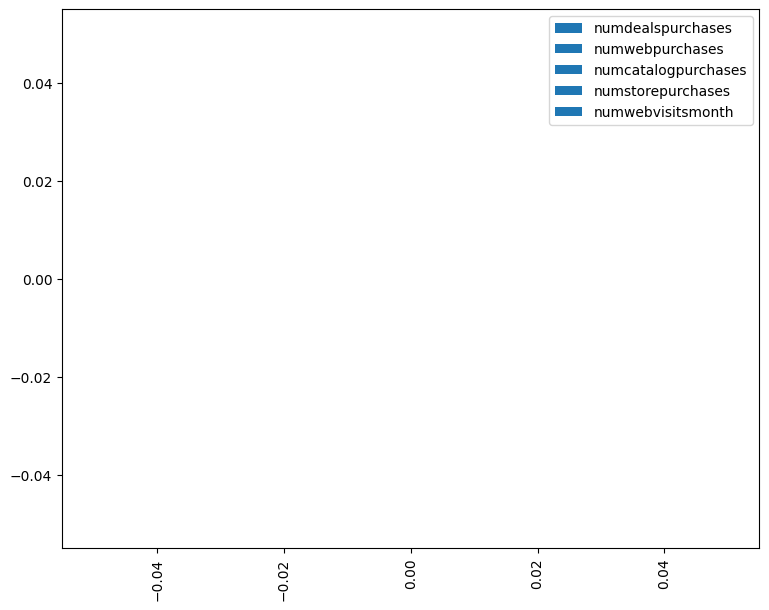

In [29]:
cluster_purchases = df1.groupby('clusters')[['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases',
                                                  'numstorepurchases', 'numwebvisitsmonth']].sum()

cluster_purchases.plot(kind='bar', color=['#dc4c4c','#157394','#589cb4','#bcb4ac','#3c444c'], figsize=(9,7))

plt.title('Purchasing Habits by Cluster')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Purchases', fontsize=20, labelpad=20)
plt.xticks(rotation=0, ha='center')

In [ ]:
income=df[df.clusters=='1'].income.mean()

AttributeError: 'DataFrame' object has no attribute 'clusters'

In [ ]:
((55000-income)/income)*100

NameError: name 'income' is not defined

In [30]:
df.income.mean()-40000

11622.094784580499

In [31]:
result = df.groupby('clusters')['income'].agg(
    mean='mean',
    median='median',
    min='min',
    max='max'
).reset_index()

result

,clusters,mean,median,min,max


<Axes: xlabel='income', ylabel='Count'>

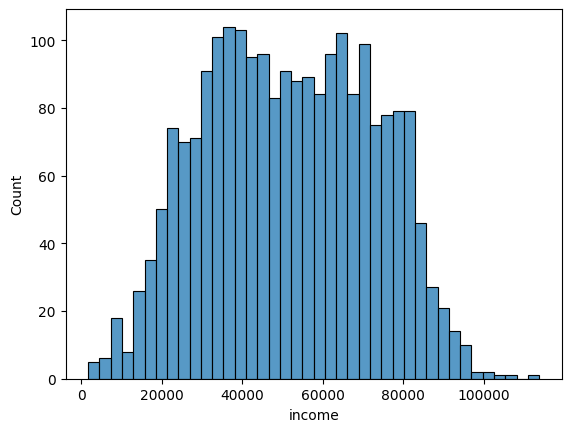

In [32]:
import seaborn as sns
sns.histplot(df.income[df.income<600000],bins=40)

In [33]:
df.income=df.income[df.income<200000]

In [34]:
maritalspending = customer.groupby('Marital_Status')['TotalSpendings'].mean().sort_values(ascending=False)
maritalspending_df = pd.DataFrame(list(maritalspending.items()), columns=['Marital Status', 'Average Spending'])

plt.figure(figsize=(13,5))
sns.barplot(data = maritalspending_df, x="Average Spending", y="Marital Status", palette='rocket')

plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.xlabel('Average Spending', fontsize=13, labelpad=13)
plt.ylabel('Marital Status', fontsize=13, labelpad=13)

NameError: name 'customer' is not defined

In [35]:
df.family_size.replace({1:'Single',2:'Partner'},inplace=True)

In [36]:
fig = px.sunburst(df, path=['family_size','education', 'children'], values='spent', color='education')
fig.show()

In [86]:
df=df[df.clusters=='0']

In [98]:
import plotly.express as px

# Define your custom colors
custom_colors = {'Partner': '#57274e', 'Single': '#b43058'}

# Create the scatter plot with custom colors
fig = px.scatter(df, x='spent', y='income', size='children', color='family_size',
                 hover_name='income', color_discrete_map=custom_colors)

# Show the scatter plot
fig.show()
